## 0. Описание проекта

В проекте используется датафрейм с данными, взятыми с сайта *transfermarkt.com*. В датафрейме содержатся данные о всех полевых футболистах Английской Прьемер-Лиги сезона 2022/2023 и их выступлении в течение сезона.

Цель проекта - провести разведочный анализ данных, представленных в датафрейме.

Проект выполнили:
* Фисенко Максим Вячеславович
* Шкода Глеб Ярославович

## 1. Импортируем библиотеки

In [ ]:
import pandas as pd
import numpy as np

import re
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import missingno as msno
from wordcloud import WordCloud
from PIL import Image

import shutil
from google.colab import files

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

## 2. Загружаем датасет

In [ ]:
dtypes={
    "name": str,
    "team": str,
    "age": str,
    "height": str,
    "nation": str,
    "position": str,
    "foot": str,
    "games": str,
    "goals": str,
    "assists": str,
    "total_minutes": str,
    "market_value": str
}


df = pd.read_csv("data.csv",
                 header=None,
                 names=["name", "team", "age", "height", "nation", "position",
                        "foot", "games", "goals", "assists", "total_minutes",
                        "market_value"],
                 dtype=dtypes
                 )

### Первоначальный вид датафрейма

In [ ]:
df.head()

,name,team,age,height,nation,position,foot,games,goals,assists,total_minutes,market_value
0,Rúben Dias,Manchester City,26,"1,87",Portugal,Defender - Centre-Back,right,26,-,-,1.996',€75.00m
1,Nathan Aké,Manchester City,28,"1,80",Netherlands,Defender - Centre-Back,left,26,1,-,1.876',€35.00m
2,John Stones,Manchester City,29,"1,88",England,Defender - Centre-Back,right,23,2,2,1.848',€30.00m
3,Aymeric Laporte,Manchester City,29,"1,89",Spain,Defender - Centre-Back,left,12,-,-,993',€30.00m
4,Manuel Akanji,Manchester City,27,"1,88",Switzerland,Defender - Centre-Back,right,29,-,1,2.283',€30.00m


Признаки, который содержит датасет на начальном этапе без предварительной обработки:

1. **name (str)** - имя футболиста
2. **team (str)** - команда, за которую играет футболист
3. **age (str)** - возраст футболиста
4. **height (str)** - рост футболиста
5. **nation (str)** - национальность футболиста
6. **position (str)** - позиция футболиста
7. **foot (str)** - ведущая нога футболиста (правая / левая)
8. **games (str)** - количество игр, сыгранных в этом сезоне Премьер-Лиги
9. **goals (str)** - количество забитых голов в этом сезоне
10. **assists (str)** - количество отданных голевых передач в этом сезоне
11. **total_minutes (str)** - суммарное количество минут, сыгранных в этом сезоне
12. **market_value (str)** - трансферная стоимость футболиста

Размеры датасета

In [ ]:
print("Всего строк: ", df.shape[0])
print("Всего колонок:", df.shape[1])

Всего строк:  498
Всего колонок: 12


## 3. Предобработка датасета

Смотрим, насколько заполнена каждая из колонок.

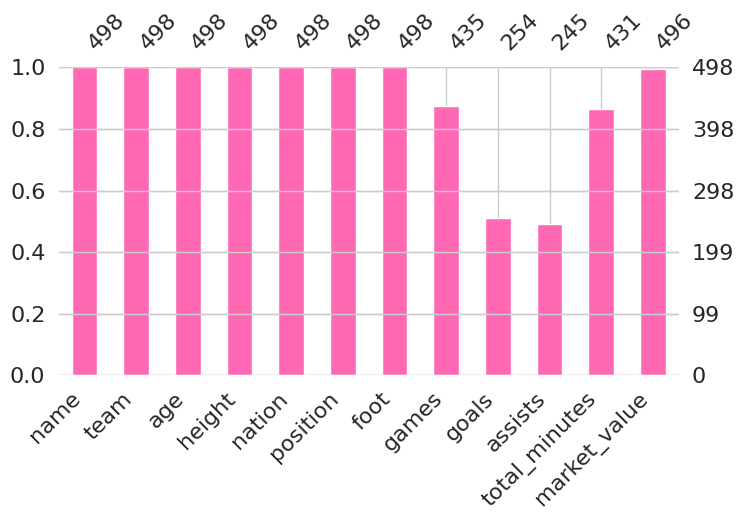

In [ ]:
df = df.replace('-', np.nan)

fig, ax = plt.subplots(figsize=(8, 4))
msno.bar(df, color='hotpink', ax=ax);

Удаляем строки с футболистами, у которых нет значения *market_value*.

In [ ]:
df = df.dropna(subset=['market_value'])
print("Всего строк: ", df.shape[0])
print("Всего колонок:", df.shape[1])

Всего строк:  496
Всего колонок: 12


По числу строк видим, что таких футболистов было 2.

Приводим колонку *age* к типу *int*.

In [ ]:
df['age'] = df['age'].astype('int')

<ipython-input-318-c7bcdba7442d>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Приводим рост в колонке *height* к целочисленному типу (рост в сатниметрах).

In [ ]:
df['height'] = df['height'].str.extract(r'([12]).\d{2}').astype('int') * 100 + \
  df['height'].str.extract(r'[12].(\d{2})').astype('int')
df.head()

<ipython-input-319-915505b1925a>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,name,team,age,height,nation,position,foot,games,goals,assists,total_minutes,market_value
0,Rúben Dias,Manchester City,26,187,Portugal,Defender - Centre-Back,right,26,NaN,NaN,1.996',€75.00m
1,Nathan Aké,Manchester City,28,180,Netherlands,Defender - Centre-Back,left,26,1,NaN,1.876',€35.00m
2,John Stones,Manchester City,29,188,England,Defender - Centre-Back,right,23,2,2,1.848',€30.00m
3,Aymeric Laporte,Manchester City,29,189,Spain,Defender - Centre-Back,left,12,NaN,NaN,993',€30.00m
4,Manuel Akanji,Manchester City,27,188,Switzerland,Defender - Centre-Back,right,29,NaN,1,2.283',€30.00m


Приводим колонку *position* к более удобному для обработки виду, разбив её на 2 колонки.

In [ ]:
df['main_position'] = df['position'].str.extract(
    r'\s*(\w+)\s*[-\s]\s*\w+[-\s]\w+',
    flags=re.IGNORECASE).astype('str')

df['sub_position'] = df['position'].str.extract(
    r'\s*\w+\s*[-\s]\s*(\w+[-\s]\w+)',
    flags=re.IGNORECASE).astype('str')

df['sub_position'] = df['sub_position'].str.replace('-', ' ')
df['sub_position'] = df['sub_position'].apply(str.lower)
df['main_position'] = df['main_position'].apply(str.lower)

Теперь вместо колонки *position* у нас колонки *main_position* и *subposition*.

In [ ]:
df = df.drop(['position'], axis=1)
df.sample(5)

,name,team,age,height,nation,foot,games,goals,assists,total_minutes,market_value,main_position,sub_position
243,James Justin,Leicester City,25,183,England,right,14,NaN,1,1.254',€25.00m,defender,right back
192,Álex Moreno,Aston Villa,29,179,Spain,left,19,NaN,3,1.334',€20.00m,defender,left back
327,Stuart Dallas,Leeds United,32,183,Northern Ireland,right,NaN,NaN,NaN,NaN,€2.00m,defender,right back
432,Jack Colback,Nottingham Forest,33,177,England,left,11,NaN,NaN,492',€800k,midfield,defensive midfield
249,Youri Tielemans,Leicester City,26,176,Belgium,right,31,3,2,2.351',€30.00m,midfield,central midfield


Значения в колонке *foot* могут принимать только два значения (*right* или *left*), поэтому логичным будет привести колонку *foot* к типу *bool*.

In [ ]:
df['right_foot'] = df['foot'].apply(lambda x: True if x == 'right' else False)
df.sample(5)

,name,team,age,height,nation,foot,games,goals,assists,total_minutes,market_value,main_position,sub_position,right_foot
405,Josh Dasilva,Brentford FC,24,184,England,left,36,4,2,1.380',€9.00m,midfield,central midfield,False
244,Ricardo Pereira,Leicester City,29,175,Portugal,right,10,1,1,451',€12.00m,defender,right back,True
397,Charlie Goode,Brentford FC,27,196,England,right,NaN,NaN,NaN,NaN,€600k,defender,centre back,True
484,Harrison Reed,Fulham FC,28,181,England,right,37,3,4,2.879',€15.00m,midfield,central midfield,True
243,James Justin,Leicester City,25,183,England,right,14,NaN,1,1.254',€25.00m,defender,right back,True


Таким образом у нас появилась колонка *right_foot*.

In [ ]:
df = df.drop(['foot'], axis=1)

Обрабатываем пустые значения в колонках *games*, *goals*, *assists*.

In [ ]:
for col in ['games', 'goals', 'assists']:
  df[col] = df[col].fillna(0)
  df[col] = df[col].astype('int')

df.sample(5)

,name,team,age,height,nation,games,goals,assists,total_minutes,market_value,main_position,sub_position,right_foot
432,Jack Colback,Nottingham Forest,33,177,England,11,0,0,492',€800k,midfield,defensive midfield,False
160,Ciaran Clark,Newcastle United,33,185,Ireland,0,0,0,NaN,€600k,defender,centre back,False
167,Emil Krafth,Newcastle United,28,184,Sweden,1,0,0,NaN,€4.00m,defender,right back,True
463,Will Hughes,Crystal Palace,28,185,England,27,1,1,828',€5.00m,midfield,central midfield,False
460,Jairo Riedewald,Crystal Palace,26,182,Netherlands,6,0,0,57',€4.00m,midfield,defensive midfield,False


Приведение *total_minutes* к *int* и обработка пустых значений.

In [ ]:
df['total_minutes'] = df['total_minutes'].fillna("0'")
df['total_minutes'] = df['total_minutes'].str.replace('.', '')
df['total_minutes'] = df['total_minutes'].str.extract(r"(\d+)'")
df['total_minutes'] = df['total_minutes'].astype('int')
df.sample(5)

,name,team,age,height,nation,games,goals,assists,total_minutes,market_value,main_position,sub_position,right_foot
288,Sékou Mara,Southampton FC,20,183,France,22,1,2,541,€12.00m,attack,centre forward,True
205,Jaden Philogene,Aston Villa,21,181,England,0,0,0,0,€2.80m,attack,left winger,True
30,Reece James,Chelsea FC,23,180,England,16,1,1,1244,€70.00m,defender,right back,True
83,Trent Alexander-Arnold,Liverpool FC,24,180,England,37,2,9,2930,€65.00m,defender,right back,True
110,Tyrell Malacia,Manchester United,23,169,Netherlands,22,0,0,1390,€22.00m,defender,left back,False


Обрабатываем колонку с ценой футболиста: создаем колонку *market_value_m*, в которой будет указана цена футболиста в миллионах евро.

In [ ]:
def convert_price(s):
  if s[-1] == 'm':
    return float(s[1:-1])
  else:
    return float(s[1:-1]) / 1000

df['market_value_m'] = df['market_value'].apply(convert_price)
df['market_value_m'] = df['market_value_m'].astype(float)

df.sample(5)

,name,team,age,height,nation,games,goals,assists,total_minutes,market_value,main_position,sub_position,right_foot,market_value_m
377,Jakub Moder,Brighton & Hove Albion,24,191,Poland,0,0,0,0,€12.00m,midfield,central midfield,True,12.0
21,Wesley Fofana,Chelsea FC,22,186,France,15,1,0,1185,€65.00m,defender,centre back,True,65.0
198,Marvelous Nakamba,Aston Villa,29,177,Zimbabwe,0,0,0,0,€4.00m,midfield,defensive midfield,False,4.0
47,Armando Broja,Chelsea FC,21,191,Albania,12,1,1,286,€30.00m,attack,centre forward,True,30.0
240,Luke Thomas,Leicester City,21,181,England,17,0,0,1070,€10.00m,defender,left back,False,10.0


In [ ]:
df = df.drop(['market_value'], axis=1)

### Итоговый вид датафрейма после предобработки

In [ ]:
df.head()

,name,team,age,height,nation,games,goals,assists,total_minutes,main_position,sub_position,right_foot,market_value_m
0,Rúben Dias,Manchester City,26,187,Portugal,26,0,0,1996,defender,centre back,True,75.0
1,Nathan Aké,Manchester City,28,180,Netherlands,26,1,0,1876,defender,centre back,False,35.0
2,John Stones,Manchester City,29,188,England,23,2,2,1848,defender,centre back,True,30.0
3,Aymeric Laporte,Manchester City,29,189,Spain,12,0,0,993,defender,centre back,False,30.0
4,Manuel Akanji,Manchester City,27,188,Switzerland,29,0,1,2283,defender,centre back,True,30.0


Признаки, который содержит датасет после предварительной обработки:

1. **name (str)** - имя футболиста
2. **team (str)** - команда, за которую играет футболист
3. **age (int)** - возраст футболиста
4. **height (int)** - рост футболиста
5. **nation (str)** - национальность футболиста
6. **games (int)** - количество игр, сыгранных в этом сезоне Премьер-Лиги
7. **goals (int)** - количество забитых голов в этом сезоне
8. **assists (int)** - количество отданных голевых передач в этом сезоне
9. **total_minutes (int)** - суммарное количество минут, сыгранных в этом сезоне
10. **main_position (str)** - общая позиция футболиста
11. **sub_position (str)** - детальная позиция футболиста
12. **right_foot (bool)** - является ли футболист "правоногим"
13. **market_value_m (float)** - трансферная стоимость футболиста в миллионах евро

## 4. Анализ датасета

### Исследование переменных

#### *team*

Посмотрим на количество игроков в каждой из команд.

In [ ]:
fig = px.histogram(df, x="team", width=800,
                   title="Количество игроков в каждой команде")
fig.show()

Видим, что распределение почти равномерное, в каждой команде примерно одинаковое количество игроков.

#### *age*

Далее рассмотрим распределение возрасту.

In [ ]:
fig = px.histogram(df, x="age", width=800,
                   title="Распределение футболистов по возрасту")
fig.show()

Распределение близко к нормальному. Видно, что больше всего игроков в возрасте 26 лет.

Можем посчитать средний возраст, моду и медиану.

In [ ]:
print("Средний возраст: ", np.mean(df.age))
print("           Мода: ", int(df.age.mode()),
      "(ее мы также определили по графику)")
print("        Медиана: ", int(np.median(df.age)))

Средний возраст:  25.995967741935484
           Мода:  26 (ее мы также определили по графику)
        Медиана:  26


#### *height*

Посмотрим распределение по росту.

In [ ]:
fig = px.histogram(df, x="height", width=800,
                   title="Распределение футболистов по росту")
fig.show()

Распределение также близко к нормальному.

#### *nation*

Посмотрим на распределение по национальностям.

In [ ]:
print("Количество разных национальностей:", df.nation.nunique())

Количество разных национальностей: 60


In [ ]:
nations_count = df.nation.value_counts(normalize=True)\
  .sort_values(ascending=False)
top_nations = nations_count[:6]
others_count = nations_count[6:].sum()

pie_data = pd.concat([top_nations, pd.Series({"Others": others_count})])

fig = px.pie(pie_data,
             values=pie_data.values,
             names=pie_data.index,
             title="Распределение по национальностям",
             width=800)
fig.show()

Преобладают футболисты из Англии, что логично, учитывая то, что мы рассматриваем статистику Английской Премьер-Лиги. Однако также довольно много представителей Бразилии, Франции, Португалии.

#### *games*

Смотрим распределение по количеству игр.

In [ ]:
fig = px.histogram(df, x="games", width=800,
                   title="Распределение по кол-ву сыгранных игр",
                   nbins=39)
fig.show()

Видим, что есть большое количество футболистов, не сыгравших за сезон ни одной игры. Посмотрим, о каких именно футболистах идет речь.

In [ ]:
df_zero_games = df[df["games"] == 0]

In [ ]:
fig = px.histogram(df_zero_games, x="age", width=800, nbins=25,
                   title="Распределение футболистов, не сыгравших ни одной игры, по возрасту")
fig.show()

Можем сделать вывод: большинство футболистов, не сыгравших ни одной игры в сезоне, - молодые футболисты возрастом до 23 лет.

#### *goals, assists*

Распределения по количеству голов и голевых передач.

In [ ]:
fig1 = px.histogram(df, x="goals")
fig2 = px.histogram(df, x="assists")

fig = sp.make_subplots(rows=1, cols=2)

fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

fig.update_layout(title='Распределение по кол-ву голов, ассистов')
fig.show()

Видим, что голы и голевые передачи распределены экспоненциально. Можем посмотреть на игроков с максимальным кол-вом голов и голевых передач.

In [ ]:
df[df.goals == df.goals.max()]

,name,team,age,height,nation,games,goals,assists,total_minutes,main_position,sub_position,right_foot,market_value_m
19,Erling Haaland,Manchester City,22,195,Norway,35,36,8,2777,attack,centre forward,False,170.0


In [ ]:
df[df.assists == df.assists.max()]

,name,team,age,height,nation,games,goals,assists,total_minutes,main_position,sub_position,right_foot,market_value_m
13,Kevin De Bruyne,Manchester City,31,181,Belgium,32,7,18,2425,midfield,attacking midfield,True,80.0


#### *sub_position*

Посмотрим на распределение игроков по позициям.

In [ ]:
fig = px.histogram(df, x="sub_position", width=800);
fig.show()

Видим, что больше всего в командах Премьер-Лиги центральных защитников, а игроков, играющих на позиции второго форварда, правого и левого полузащитников, осталось очень мало.

#### *right_foot*

Смотрим на распределение левшей и правшей в датасете.

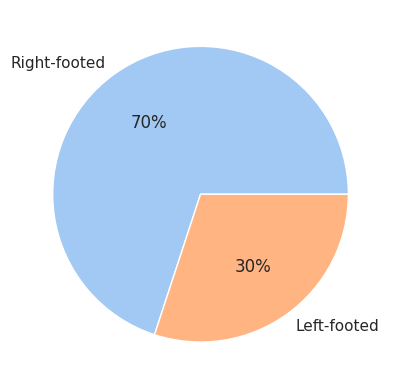

In [ ]:
values = [df[df.right_foot == True].shape[0],
          df[df.right_foot == False].shape[0]]
colors = sns.color_palette('pastel')[:2]
plt.pie(values, labels=['Right-footed', 'Left-footed'],
        colors=colors, autopct='%.0f%%');

Видим, что "правоногие футболисты" составляют 70% от всех футболистов.

#### *market_value_m*

Нацонец, можем посмотреть на распределение футболистов по их трансферной стоимости.

In [ ]:
fig = px.histogram(df, x="market_value_m", width=800, nbins=50,
                   title="Распределение футболистов по трансферной стоимости")
fig.show()

Распределение также похоже на экспоненциальное.

In [ ]:
print("Средняя цена футболиста: ", df.market_value_m.mean())
print("                Медиана: ", df.market_value_m.median())

Средняя цена футболиста:  19.888004032258067
                Медиана:  15.0


Самый дорогой футболист:

In [ ]:
df[df.market_value_m == df.market_value_m.max()]

,name,team,age,height,nation,games,goals,assists,total_minutes,main_position,sub_position,right_foot,market_value_m
19,Erling Haaland,Manchester City,22,195,Norway,35,36,8,2777,attack,centre forward,False,170.0


Это тот же футболист, что забил наибольшее количество голов в сезоне.

### Исследование связи между переменными

#### *team & market_value_m*

Смотрим команды с самыми дорогими игроками.

Вывыдем средние стоимости игроков в командах по убыванию.

In [ ]:
mean_market_values = df.groupby(by='team')['market_value_m'].mean()

In [ ]:
mean_market_values.sort_values(ascending=False)

team
Manchester City            50.000000
Arsenal FC                 35.680000
Chelsea FC                 33.575862
Tottenham Hotspur          32.095238
Liverpool FC               30.555556
Manchester United          24.851515
West Ham United            21.157143
Aston Villa                17.400000
Leicester City             16.270370
Newcastle United           15.953333
Everton FC                 14.850000
Wolverhampton Wanderers    14.266667
Southampton FC             13.206667
Brighton & Hove Albion     13.100000
Crystal Palace             12.756522
Brentford FC               11.740000
Leeds United               11.368966
Fulham FC                   9.725000
Nottingham Forest           9.116176
Name: market_value_m, dtype: float64

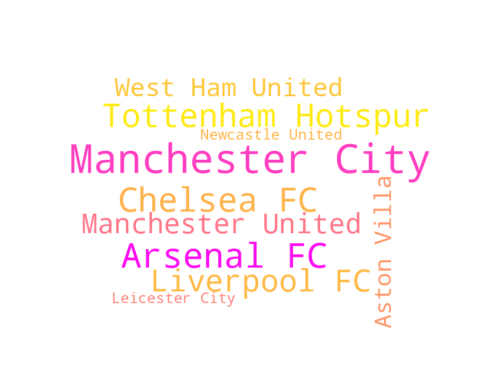

In [ ]:
url = "https://www.pinclipart.com/picdir/middle/519-5194083_cloud-clipart.png"
response = requests.get(url)
cloud_mask = np.array(Image.open(BytesIO(response.content)))

wc = WordCloud(background_color="white", max_words=10, mask=cloud_mask,
               colormap="spring")
wc.generate_from_frequencies(mean_market_values.to_dict())

plt.figure(figsize=(6, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off");

Видим, что наибольшая средняя стоимость игроков у таких команд, как *Manchester City*, *Arsenal* *FC*, *Chelsea* *FC*, *Tottenham* *FC*, *Liverpool* *FC*.

#### *sub_position & right_foot*

Посмотрим подробнее, на каких позициях чаще всего играют левоногие футболисты.

In [ ]:
position_foot_counts = df.groupby(["sub_position", "right_foot"])\
  .size().unstack(fill_value=0)
position_foot_counts_normalized = position_foot_counts\
  .div(position_foot_counts.sum(axis=1), axis=0)

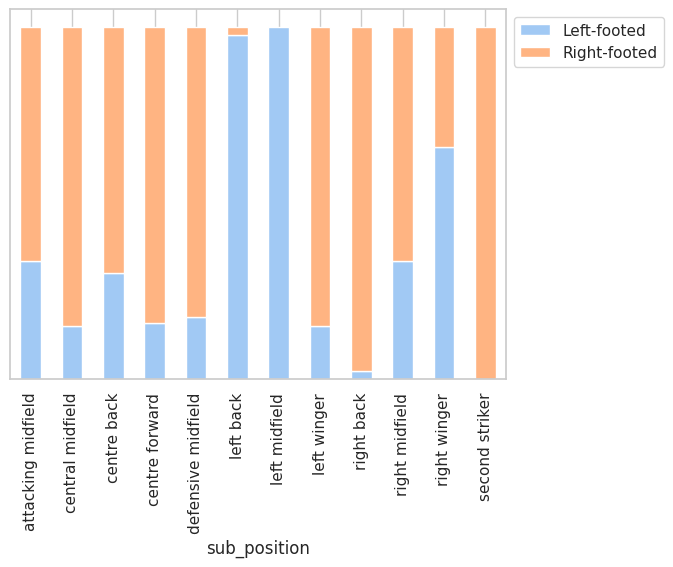

In [ ]:
sns.set(style="whitegrid", palette=sns.color_palette("pastel"))
position_foot_counts_normalized.plot(kind="bar", stacked=True)
plt.legend(["Left-footed", "Right-footed"], bbox_to_anchor=(1, 1))
plt.yticks([]);

Видим, что на позициях левого защитника и левого полузащитника играют в большинстве случаев левоногие футболисты. Также довольно много левоногих футболистов играют на позиции правого вингера.

#### *age & market_value_m*

Посмотрим распределение трансферной стоимости игроков по возрастам.

In [ ]:
tmp1 = df.groupby(by='age', as_index=False)['market_value_m'].mean().rename(
    columns={'market_value_m':'mean'}).set_index(['age'])
tmp2 = df.groupby(by='age', as_index=False)['market_value_m'].max().rename(
    columns={'market_value_m':'max'}).set_index(['age'])

tmp2['max'] = tmp2['max'] - tmp1['mean']
tmp_df = pd.concat([tmp1, tmp2], axis=1, names=['mean', 'max'])

px.bar(tmp_df, x=tmp_df.index, y=['mean', 'max'],
       color_discrete_map={'max':'deeppink', 'mean':'lightpink'},
       title='Распределение средней и максимальной трансферной стоимости' +
       ' по возрастам игроков',
       width=900,
       height=500)

Смотря на график, можно сделать вывод, что максимальную среднюю и наибольшую стоимость имеют игроки в возрасте 22 лет.

В целом можно сделать вывод, что возраст влияет на трансферную стоимость игроков. Максимальую стоимость игроки имеют в возрасте 21-23 лет, далее этот показатель идет на спад. Футболисты старше 30-31 лет имеют очень низкую стоимость.

#### *height, market_value_m*

Посмотрим, как между собой коррелируют признаки *height* и *market_value_m*.

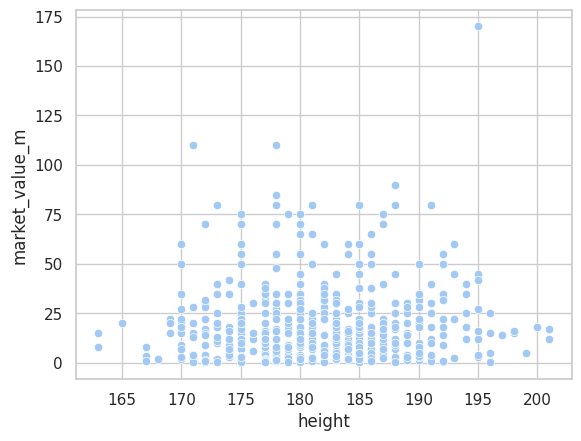

In [ ]:
sns.scatterplot(data=df, x="height", y="market_value_m");

На графике представлено распределение, очень напоминающее равномерное. Можем сделать вывод, что трансферная стоимость футболиста не зависит от его роста. Подтвердим это, рассчитав коэффициент корреляции:

In [ ]:
print("Корреляция: ", df["height"].corr(df["market_value_m"]))

Корреляция:  0.048756624220644605


Попробуем сделать то же самое с количеством игр, сыгранных в этом сезоне.

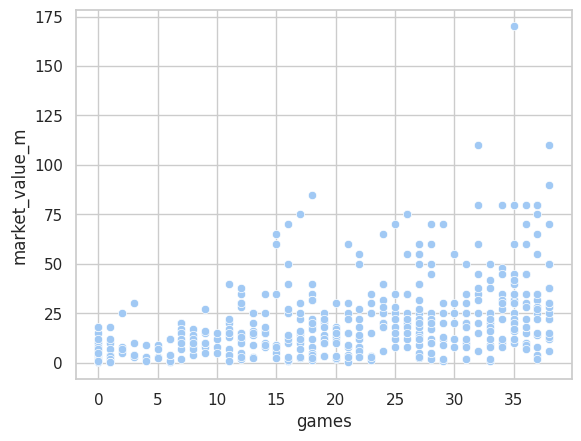

In [ ]:
sns.scatterplot(data=df, x="games", y="market_value_m");

Тут уже видна корреляция: чем больше у футболиста сыгранных матчей в сезоне, тем больше он обычно стоит. Однако мы не можем сказать, что трансферная стоимость зависит от количества проведенных игр: вполне возможно, что, наоборот, футболист играет на поле чаще, если он больше стоит.

In [ ]:
print("Корреляция: ", df["games"].corr(df["market_value_m"]))

Корреляция:  0.4840602312023682


Корреляция не самая большая, однако она гораздо больше, чем в предыдущем случае.

#### *goals & market_calue_m*

Также у нас есть колонка *goals*. Так как забивать голы в основном "задача" нападающих, есть смысл посчитать зависимость цены от результативности именно у них.

In [ ]:
df_attackers = df[df["main_position"] == "attack"]
df_attackers.head()

,name,team,age,height,nation,games,goals,assists,total_minutes,main_position,sub_position,right_foot,market_value_m
16,Phil Foden,Manchester City,23,171,England,32,11,5,1842,attack,left winger,False,110.0
17,Jack Grealish,Manchester City,27,180,England,28,5,7,2062,attack,left winger,True,70.0
18,Riyad Mahrez,Manchester City,32,179,Algeria,30,5,10,1924,attack,right winger,False,30.0
19,Erling Haaland,Manchester City,22,195,Norway,35,36,8,2777,attack,centre forward,False,170.0
20,Julián Álvarez,Manchester City,23,170,Argentina,31,9,1,1452,attack,centre forward,True,50.0


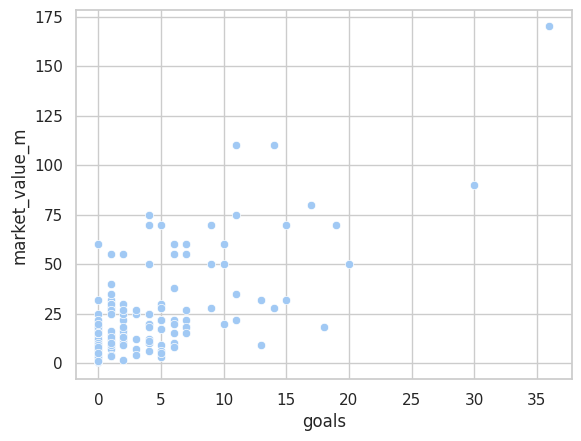

In [ ]:
sns.scatterplot(df_attackers, x="goals", y="market_value_m");

In [ ]:
print("Корреляция: ", df_attackers["goals"].corr(df["market_value_m"]))

Корреляция:  0.6990966023365343


Действительно, с увеличением количества голов в сезоне трансферная стоимость нападающих также возрастает.

#### *main_position & market_value_m*

Построим сводную таблицу, чтоб посмотреть, различается ли средняя стоимость игроков разных позиций.

In [ ]:
df_pos_value = df.pivot_table(values='market_value_m',
                              index='main_position',
                              aggfunc='mean')

df_pos_value.sort_values(by=['market_value_m'], ascending=True)

,market_value_m
main_position,
defender,16.303175
midfield,20.552532
attack,23.730537


Видим, что нападающие в среднем стоят примерно на 3 миллиона евро больше, чем полузащитники, и на 7 больше, чем защитники.

### Матрицы корреляций

Можем посмотреть на матрицу корреляций для датасета с нападающими.

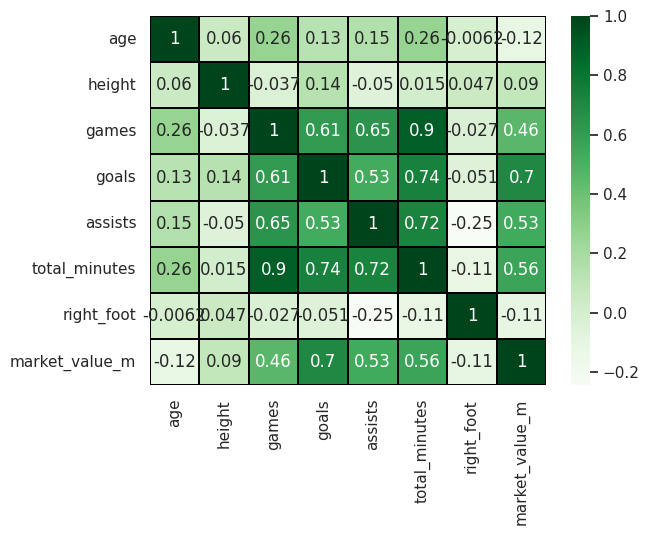

In [ ]:
sns.heatmap(df_attackers.corr(),
            annot=True,
            cmap="Greens",
            linewidths=0.2,
            linecolor="black",
            );

Видим, что трансферная стоимость нападающих коррелирует, помимо голов, также с количеством голевых передач и времени, проведенном на поле, однако уже не так сильно.

Попробуем сделать то же самое, но с полузащитниками.

In [ ]:
df_midfielders = df[df["main_position"] == "midfield"]
df_midfielders.head()

,name,team,age,height,nation,games,goals,assists,total_minutes,main_position,sub_position,right_foot,market_value_m
9,Rodri,Manchester City,26,191,Spain,36,2,6,2920,midfield,defensive midfield,True,80.0
10,Kalvin Phillips,Manchester City,27,179,England,12,0,0,290,midfield,defensive midfield,True,35.0
11,Máximo Perrone,Manchester City,20,177,Argentina,1,0,0,18,midfield,defensive midfield,False,10.0
12,Ilkay Gündogan,Manchester City,32,180,Germany,31,8,5,2359,midfield,central midfield,True,25.0
13,Kevin De Bruyne,Manchester City,31,181,Belgium,32,7,18,2425,midfield,attacking midfield,True,80.0


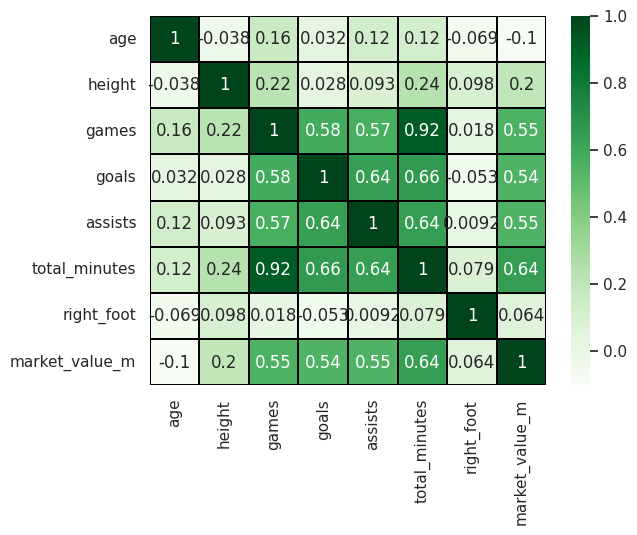

In [ ]:
sns.heatmap(df_midfielders.corr(),
            annot=True,
            cmap="Greens",
            linewidths=0.2,
            linecolor="black",
            );

Видим, что сильной коррелиции между трансферной стоимостью и каким-либо признаком тут нет.

Однако мы не учли один факт: полузащитники делятся на оборонительных, обычных и атакующих. У оборонительных полузащитников нет цели отдавать голевые передачи, в то время как у атакующих полузащитников это прямая задача.

Попробуем сделать датасет с атакующими полузущитниками и проанализировать его.

In [ ]:
df_attacking_midfielders = df[df["sub_position"] == "attacking midfield"]
df_attacking_midfielders.head()

,name,team,age,height,nation,games,goals,assists,total_minutes,main_position,sub_position,right_foot,market_value_m
13,Kevin De Bruyne,Manchester City,31,181,Belgium,32,7,18,2425,midfield,attacking midfield,True,80.0
14,Bernardo Silva,Manchester City,28,173,Portugal,34,4,6,2202,midfield,attacking midfield,False,80.0
15,Cole Palmer,Manchester City,21,189,England,14,0,1,358,midfield,attacking midfield,False,15.0
39,Mason Mount,Chelsea FC,24,181,England,24,3,2,1655,midfield,attacking midfield,True,65.0
40,Kai Havertz,Chelsea FC,23,193,Germany,35,7,1,2578,midfield,attacking midfield,False,60.0


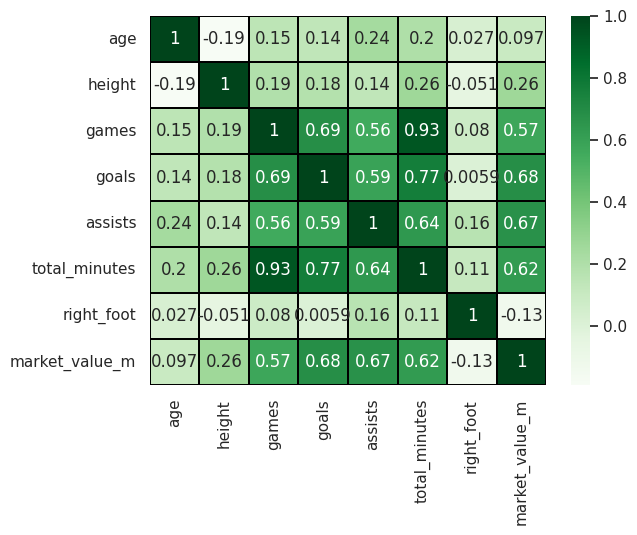

In [ ]:
sns.heatmap(df_attacking_midfielders.corr(),
            annot=True,
            cmap="Greens",
            linewidths=0.2,
            linecolor="black",
            );

Тут уже видно корреляцию: трансферная стоимость атакающего полузащитника довольно неплохо коррелирует с количеством его голов и голевых передач.

## 5. Итог

Мы провели разведочный анализ данных датафрейма. В результаты мы:
* провели предобработку датасета, сделав его более удобным для работы
* исследовали и визуализировали поведение переменных
* исследовали и визуализировали связь между переменными
* сделали выводы, которые будут полезными для дальнейшей работы с датафреймом в рамках применения алгоритмов машинного обучения.
